<a href="https://colab.research.google.com/github/felipeacioli/mvpsoftwareinteligente/blob/main/MVP_modelo.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## MVP - Engenharia de Sistemas de Software Inteligentes - Modelo para predição da potabilidade da água com base nos seguintes parâmetros: ph, dureza, sólidos, cloraminas, sulfato, condutividade, carbono orgânico, trihalometanos e turbidez.


Este modelo Indica se a água é segura para consumo humano, onde 1 significa potável e 0 significa não potável.

In [ ]:
# configuração para não exibir os warnings
import warnings
warnings.filterwarnings("ignore")

# Imports necessários
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import accuracy_score
from sklearn.pipeline import Pipeline
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC
import pickle
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import BaggingClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.ensemble import VotingClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.ensemble import GradientBoostingClassifier


## Carga do Dataset

In [ ]:
# Informa a URL de importação do dataset
url = "https://raw.githubusercontent.com/felipeacioli/mvpsoftwareinteligente/main/water_potability.csv"

# Lê o arquivo
dataset = pd.read_csv(url, delimiter=',')

# Elimina linhas que tenha algum campo com valor NaN

print(dataset.shape)

dataset = dataset.dropna(axis=0)

print(dataset.shape)

# Mostra as primeiras linhas do dataset
dataset.head()




(3276, 10)
(2011, 10)


,ph,Hardness,Solids,Chloramines,Sulfate,Conductivity,Organic_carbon,Trihalomethanes,Turbidity,Potability
3,8.316766,214.373394,22018.417441,8.059332,356.886136,363.266516,18.436524,100.341674,4.628771,0
4,9.092223,181.101509,17978.986339,6.546600,310.135738,398.410813,11.558279,31.997993,4.075075,0
5,5.584087,188.313324,28748.687739,7.544869,326.678363,280.467916,8.399735,54.917862,2.559708,0
6,10.223862,248.071735,28749.716544,7.513408,393.663396,283.651634,13.789695,84.603556,2.672989,0
7,8.635849,203.361523,13672.091764,4.563009,303.309771,474.607645,12.363817,62.798309,4.401425,0


## Separação em conjunto de treino e conjunto de teste com holdout

In [ ]:
test_size = 0.20 # tamanho do conjunto de teste
seed = 7 # semente aleatória

# Separação em conjuntos de treino e teste
array = dataset.values
X = array[:,0:9]
y = array[:,9]
X_train, X_test, y_train, y_test = train_test_split(X, y,
    test_size=test_size, shuffle=True, random_state=seed, stratify=y) # holdout com estratificação

# Parâmetros e partições da validação cruzada
scoring = 'accuracy'
num_particoes = 10
kfold = StratifiedKFold(n_splits=num_particoes, shuffle=True, random_state=seed) # validação cruzada com estratificação



```
# Isto está formatado como código
```

## Modelagem e Inferência

### Criação e avaliação de modelos: linha base

LR: 0.597019 (0.003152)
KNN: 0.558459 (0.035256)
CART: 0.587721 (0.035681)
NB: 0.619422 (0.033020)
SVM: 0.597019 (0.001491)
Bagging: 0.690314 (0.021974)
RF: 0.682822 (0.021173)
ET: 0.687822 (0.028846)
Ada: 0.570268 (0.023737)
GB: 0.652981 (0.031310)
Voting: 0.597640 (0.002184)


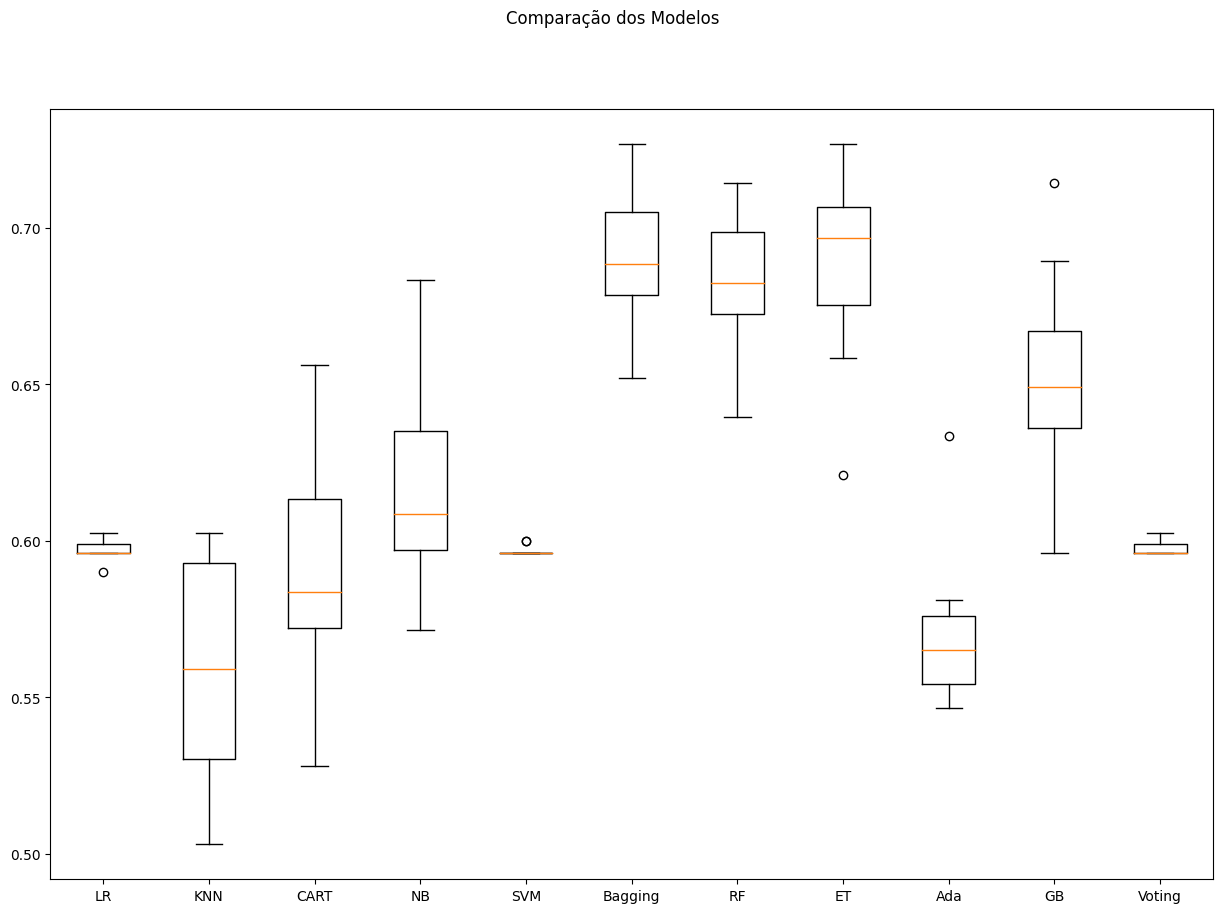

In [ ]:
np.random.seed(7) # definindo uma semente global

# Lista que armazenará os modelos
models = []

# Criando os modelos e adicionando-os na lista de modelos
models.append(('LR', LogisticRegression(max_iter=200)))
models.append(('KNN', KNeighborsClassifier()))
models.append(('CART', DecisionTreeClassifier()))
models.append(('NB', GaussianNB()))
models.append(('SVM', SVC()))

# Definindo os parâmetros do classificador base para o BaggingClassifier
base = DecisionTreeClassifier()
num_trees = 100
max_features = 3

# Criando os modelos para o VotingClassifier
bases = []
model1 = LogisticRegression(max_iter=200)
bases.append(('logistic', model1))
model2 = DecisionTreeClassifier()
bases.append(('cart', model2))
model3 = SVC()
bases.append(('svm', model3))

# Criando os ensembles e adicionando-os na lista de modelos
models.append(('Bagging', BaggingClassifier(estimator=base, n_estimators=num_trees)))
models.append(('RF', RandomForestClassifier(n_estimators=num_trees, max_features=max_features)))
models.append(('ET', ExtraTreesClassifier(n_estimators=num_trees, max_features=max_features)))
models.append(('Ada', AdaBoostClassifier(n_estimators=num_trees)))
models.append(('GB', GradientBoostingClassifier(n_estimators=num_trees)))
models.append(('Voting', VotingClassifier(bases)))


# Listas para armazenar os resultados
results = []
names = []

# Avaliação dos modelos
for name, model in models:
    cv_results = cross_val_score(model, X_train, y_train, cv=kfold, scoring=scoring)
    results.append(cv_results)
    names.append(name)
    msg = "%s: %f (%f)" % (name, cv_results.mean(), cv_results.std())
    print(msg)

# Boxplot de comparação dos modelos
fig = plt.figure(figsize=(15,10))
fig.suptitle('Comparação dos Modelos')
ax = fig.add_subplot(111)
plt.boxplot(results)
ax.set_xticklabels(names)
plt.show()

### Criação e avaliação de modelos: dados padronizados e normalizados

LR-orig: 0.597 (0.003)
KNN-orig: 0.558 (0.035)
CART-orig: 0.588 (0.036)
NB-orig: 0.619 (0.033)
SVM-orig: 0.597 (0.001)
Bag-orig: 0.690 (0.022)
RF-orig: 0.683 (0.021)
ET-orig: 0.688 (0.029)
Ada-orig: 0.570 (0.024)
GB-orig: 0.653 (0.031)
Vot-orig: 0.598 (0.002)
LR-padr: 0.597 (0.003)
KNN-padr: 0.641 (0.031)
CART-padr: 0.590 (0.041)
NB-padr: 0.621 (0.035)
SVM-padr: 0.685 (0.022)
Bag-padr: 0.699 (0.027)
RF-padr: 0.688 (0.022)
ET-padr: 0.690 (0.026)
Ada-padr: 0.570 (0.024)
GB-padr: 0.652 (0.030)
Vot-padr: 0.664 (0.024)
LR-norm: 0.598 (0.002)
KNN-norm: 0.614 (0.021)
CART-norm: 0.590 (0.035)
NB-norm: 0.621 (0.035)
SVM-norm: 0.678 (0.022)
Bag-norm: 0.687 (0.022)
RF-norm: 0.672 (0.021)
ET-norm: 0.679 (0.021)
Ada-norm: 0.570 (0.024)
GB-norm: 0.655 (0.027)
Vot-norm: 0.663 (0.019)


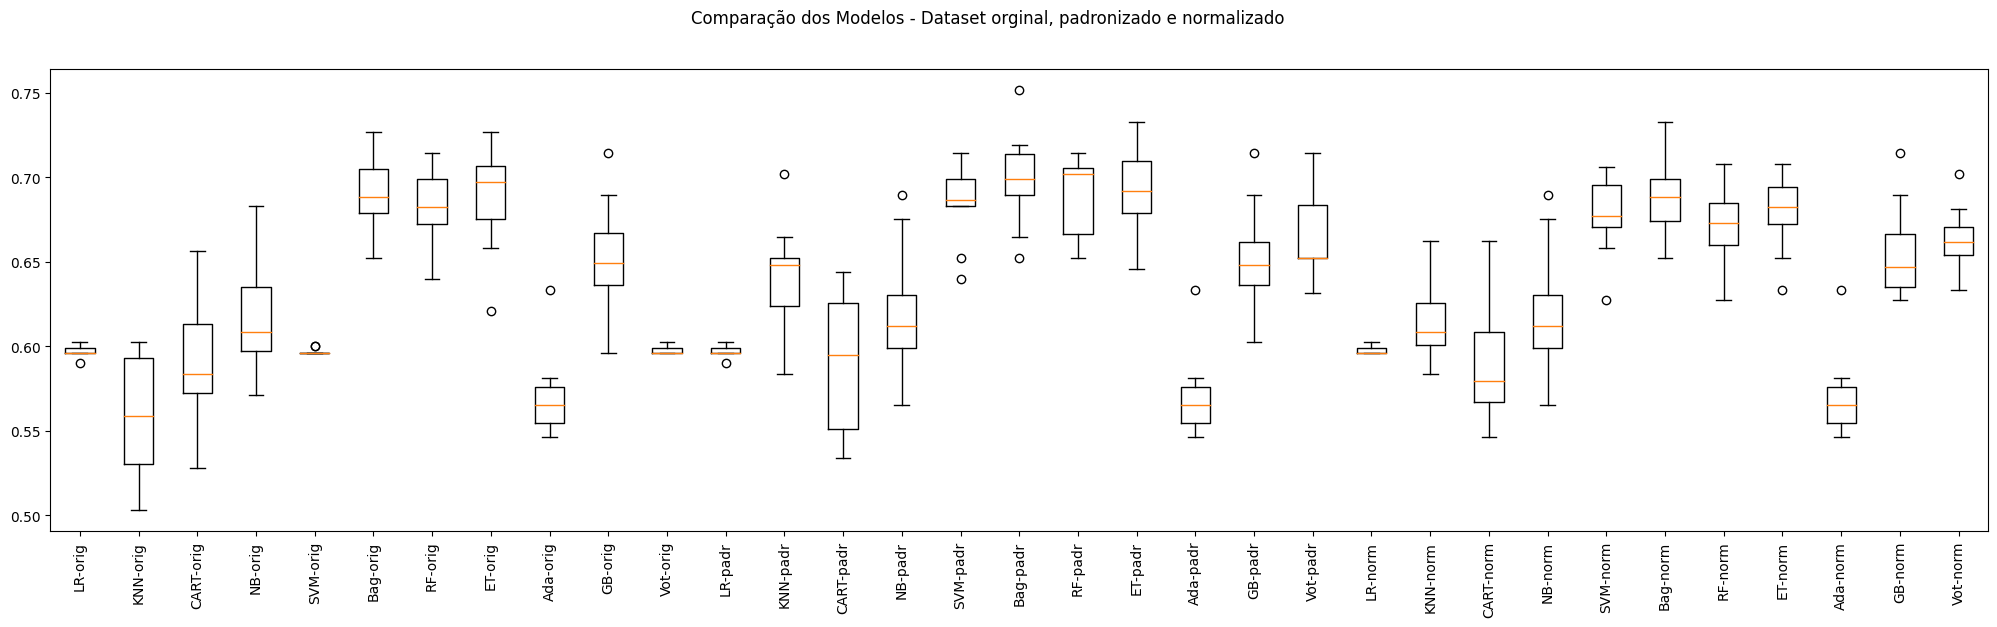

In [ ]:
np.random.seed(7) # definindo uma semente global para este bloco

# Listas para armazenar os armazenar os pipelines e os resultados para todas as visões do dataset
pipelines = []
results = []
names = []


# Criando os elementos do pipeline

# Algoritmos que serão utilizados
reg_log = ('LR', LogisticRegression(max_iter=200))
knn = ('KNN', KNeighborsClassifier())
cart = ('CART', DecisionTreeClassifier())
naive_bayes = ('NB', GaussianNB())
svm = ('SVM', SVC())
bagging = ('Bag', BaggingClassifier(estimator=base, n_estimators=num_trees))
random_forest = ('RF', RandomForestClassifier(n_estimators=num_trees, max_features=max_features))
extra_trees = ('ET', ExtraTreesClassifier(n_estimators=num_trees, max_features=max_features))
adaboost = ('Ada', AdaBoostClassifier(n_estimators=num_trees))
gradient_boosting = ('GB', GradientBoostingClassifier(n_estimators=num_trees))
voting = ('Voting', VotingClassifier(bases))


# Transformações que serão utilizadas
standard_scaler = ('StandardScaler', StandardScaler())
min_max_scaler = ('MinMaxScaler', MinMaxScaler())


# Montando os pipelines

# Dataset original
pipelines.append(('LR-orig', Pipeline([reg_log])))
pipelines.append(('KNN-orig', Pipeline([knn])))
pipelines.append(('CART-orig', Pipeline([cart])))
pipelines.append(('NB-orig', Pipeline([naive_bayes])))
pipelines.append(('SVM-orig', Pipeline([svm])))
pipelines.append(('Bag-orig', Pipeline([bagging])))
pipelines.append(('RF-orig', Pipeline([random_forest])))
pipelines.append(('ET-orig', Pipeline([extra_trees])))
pipelines.append(('Ada-orig', Pipeline([adaboost])))
pipelines.append(('GB-orig', Pipeline([gradient_boosting])))
pipelines.append(('Vot-orig', Pipeline([voting])))

# Dataset Padronizado
pipelines.append(('LR-padr', Pipeline([standard_scaler, reg_log])))
pipelines.append(('KNN-padr', Pipeline([standard_scaler, knn])))
pipelines.append(('CART-padr', Pipeline([standard_scaler, cart])))
pipelines.append(('NB-padr', Pipeline([standard_scaler, naive_bayes])))
pipelines.append(('SVM-padr', Pipeline([standard_scaler, svm])))
pipelines.append(('Bag-padr', Pipeline([standard_scaler, bagging])))
pipelines.append(('RF-padr', Pipeline([standard_scaler, random_forest])))
pipelines.append(('ET-padr', Pipeline([standard_scaler, extra_trees])))
pipelines.append(('Ada-padr', Pipeline([standard_scaler, adaboost])))
pipelines.append(('GB-padr', Pipeline([standard_scaler, gradient_boosting])))
pipelines.append(('Vot-padr', Pipeline([standard_scaler, voting])))

# Dataset Normalizado
pipelines.append(('LR-norm', Pipeline([min_max_scaler, reg_log])))
pipelines.append(('KNN-norm', Pipeline([min_max_scaler, knn])))
pipelines.append(('CART-norm', Pipeline([min_max_scaler, cart])))
pipelines.append(('NB-norm', Pipeline([min_max_scaler, naive_bayes])))
pipelines.append(('SVM-norm', Pipeline([min_max_scaler, svm])))
pipelines.append(('Bag-norm', Pipeline([min_max_scaler, bagging])))
pipelines.append(('RF-norm', Pipeline([min_max_scaler, random_forest])))
pipelines.append(('ET-norm', Pipeline([min_max_scaler, extra_trees])))
pipelines.append(('Ada-norm', Pipeline([min_max_scaler, adaboost])))
pipelines.append(('GB-norm', Pipeline([min_max_scaler, gradient_boosting])))
pipelines.append(('Vot-norm', Pipeline([min_max_scaler, voting])))

# Executando os pipelines
for name, model in pipelines:
    cv_results = cross_val_score(model, X_train, y_train, cv=kfold, scoring=scoring)
    results.append(cv_results)
    names.append(name)
    msg = "%s: %.3f (%.3f)" % (name, cv_results.mean(), cv_results.std()) # formatando para 3 casas decimais
    print(msg)

# Boxplot de comparação dos modelos
fig = plt.figure(figsize=(25,6))
fig.suptitle('Comparação dos Modelos - Dataset orginal, padronizado e normalizado')
ax = fig.add_subplot(111)
plt.boxplot(results)
ax.set_xticklabels(names, rotation=90)
plt.show()

### Otimização dos hiperparâmetros

In [ ]:
np.random.seed(7)  # Definindo uma semente global para este bloco

# Lista de modelos
models = []

# Criando os modelos e adicionando-os na lista de modelos
models.append(('LR', LogisticRegression(max_iter=200)))
models.append(('KNN', KNeighborsClassifier()))
models.append(('CART', DecisionTreeClassifier()))
models.append(('NB', GaussianNB()))
models.append(('SVM', SVC()))

# Definindo os parâmetros do classificador base para o BaggingClassifier
base = DecisionTreeClassifier()
num_trees = 100
max_features = 3

# Criando os modelos para o VotingClassifier
bases = []
model1 = LogisticRegression(max_iter=200)
bases.append(('logistic', model1))
model2 = DecisionTreeClassifier()
bases.append(('cart', model2))
model3 = SVC()
bases.append(('svm', model3))

# Criando os ensembles e adicionando-os na lista de modelos
models.append(('Bagging', BaggingClassifier(estimator=base, n_estimators=num_trees)))
models.append(('RF', RandomForestClassifier(n_estimators=num_trees, max_features=max_features)))
models.append(('ET', ExtraTreesClassifier(n_estimators=num_trees, max_features=max_features)))
models.append(('Ada', AdaBoostClassifier(n_estimators=num_trees)))
models.append(('GB', GradientBoostingClassifier(n_estimators=num_trees)))
models.append(('Voting', VotingClassifier(estimators=bases, voting='hard')))

# Definindo os componentes do pipeline
standard_scaler = ('StandardScaler', StandardScaler())
min_max_scaler = ('MinMaxScaler', MinMaxScaler())

# Lista de pipelines
pipelines = []

# Criando pipelines para cada modelo
for name, model in models:
    pipelines.append((name + '-orig', Pipeline(steps=[(name, model)])))
    pipelines.append((name + '-padr', Pipeline(steps=[standard_scaler, (name, model)])))
    pipelines.append((name + '-norm', Pipeline(steps=[min_max_scaler, (name, model)])))

# Definindo os parâmetros para GridSearchCV
param_grids = {
    'LR': {
        'LR__C': [0.01, 0.1, 1, 10, 100],
        'LR__solver': ['liblinear', 'saga']
    },
    'KNN': {
        'KNN__n_neighbors': [1, 3, 5, 7, 9, 11, 13, 15, 17, 19, 21],
        'KNN__metric': ["euclidean", "manhattan", "minkowski"]
    },
    'CART': {
        'CART__max_depth': [None, 10, 20, 30, 40, 50],
        'CART__min_samples_split': [2, 5, 10],
        'CART__min_samples_leaf': [1, 2, 4]
    },
    'NB': {
        'NB__var_smoothing': [1e-9, 1e-8, 1e-7, 1e-6, 1e-5]
    },
    'SVM': {
        'SVM__C': [0.1],
        'SVM__gamma': [1, 0.1, 0.01, 0.001],
        'SVM__kernel': ['rbf', 'linear']
    },
    'RF': {
        'RF__n_estimators': [10, 50, 100, 200],
        'RF__max_features': ['auto', 'sqrt', 'log2'],
        'RF__max_depth': [None, 10, 20, 30],
        'RF__min_samples_split': [2, 5, 10],
        'RF__min_samples_leaf': [1, 2, 4]
    },
    'ET': {
        'ET__n_estimators': [10, 50, 100, 200],
        'ET__max_features': ['auto', 'sqrt', 'log2'],
        'ET__max_depth': [None, 10, 20, 30],
        'ET__min_samples_split': [2, 5, 10],
        'ET__min_samples_leaf': [1, 2, 4]
    },
    'Ada': {
        'Ada__n_estimators': [10, 50, 100, 200],
        'Ada__learning_rate': [0.01, 0.1, 1, 10]
    },
    'GB': {
        'GB__n_estimators': [10, 50, 100, 200],
        'GB__learning_rate': [0.01, 0.1, 0.2, 0.3],
        'GB__max_depth': [3, 5, 7, 9]
    },
    'Voting': {
        # Para VotingClassifier, geralmente não há hiperparâmetros para ajustar diretamente
        # Ajustar os hiperparâmetros dos estimadores base individualmente se necessário
    }
}

# Parâmetros de cross-validation e scoring
scoring = 'accuracy'
kfold = 5

# Executando o GridSearchCV para cada pipeline
for name, pipeline in pipelines:
    model_type = name.split('-')[0]
    if model_type in param_grids:
        param_grid = param_grids[model_type]
    else:
        param_grid = {}  # Para modelos que não têm parâmetros definidos

    grid = GridSearchCV(estimator=pipeline, param_grid=param_grid, scoring=scoring, cv=kfold)
    grid.fit(X_train, y_train)
    # Imprimindo a melhor configuração
    print("Modelo: %s - Melhor: %f usando %s" % (name, grid.best_score_, grid.best_params_))

#It took 80min


Modelo: LR-orig - Melhor: 0.598880 usando {'LR__C': 0.1, 'LR__solver': 'liblinear'}
Modelo: LR-padr - Melhor: 0.599501 usando {'LR__C': 0.01, 'LR__solver': 'liblinear'}
Modelo: LR-norm - Melhor: 0.599501 usando {'LR__C': 10, 'LR__solver': 'liblinear'}
Modelo: KNN-orig - Melhor: 0.593899 usando {'KNN__metric': 'manhattan', 'KNN__n_neighbors': 9}
Modelo: KNN-padr - Melhor: 0.650471 usando {'KNN__metric': 'manhattan', 'KNN__n_neighbors': 15}
Modelo: KNN-norm - Melhor: 0.636814 usando {'KNN__metric': 'manhattan', 'KNN__n_neighbors': 13}
Modelo: CART-orig - Melhor: 0.646764 usando {'CART__max_depth': 40, 'CART__min_samples_leaf': 4, 'CART__min_samples_split': 10}
Modelo: CART-padr - Melhor: 0.647377 usando {'CART__max_depth': None, 'CART__min_samples_leaf': 2, 'CART__min_samples_split': 2}
Modelo: CART-norm - Melhor: 0.648008 usando {'CART__max_depth': 30, 'CART__min_samples_leaf': 2, 'CART__min_samples_split': 2}
Modelo: NB-orig - Melhor: 0.616294 usando {'NB__var_smoothing': 1e-08}
Modelo

In [ ]:
# Tuning do KNN

np.random.seed(7) # definindo uma semente global para este bloco

pipelines = []

# Definindo os componentes do pipeline
knn = ('KNN', KNeighborsClassifier())
standard_scaler = ('StandardScaler', StandardScaler())
min_max_scaler = ('MinMaxScaler', MinMaxScaler())

pipelines.append(('knn-orig', Pipeline(steps=[knn])))
pipelines.append(('knn-padr', Pipeline(steps=[standard_scaler, knn])))
pipelines.append(('knn-norm', Pipeline(steps=[min_max_scaler, knn])))

param_grid = {
    'KNN__n_neighbors': [1,3,5,7,9,11,13,15,17,19,21],
    'KNN__metric': ["euclidean", "manhattan", "minkowski"],
}

# Prepara e executa o GridSearchCV
for name, model in pipelines:
    grid = GridSearchCV(estimator=model, param_grid=param_grid, scoring=scoring, cv=kfold)
    grid.fit(X_train, y_train)
    # imprime a melhor configuração
    print("Sem tratamento de missings: %s - Melhor: %f usando %s" % (name, grid.best_score_, grid.best_params_))

Sem tratamento de missings: knn-orig - Melhor: 0.593899 usando {'KNN__metric': 'manhattan', 'KNN__n_neighbors': 9}
Sem tratamento de missings: knn-padr - Melhor: 0.650471 usando {'KNN__metric': 'manhattan', 'KNN__n_neighbors': 15}
Sem tratamento de missings: knn-norm - Melhor: 0.636814 usando {'KNN__metric': 'manhattan', 'KNN__n_neighbors': 13}


## Finalização do Modelo

In [ ]:
#melhor modelo: Modelo: RF-orig - Melhor: 0.692163 usando {'RF__max_depth': 30, 'RF__max_features': 'log2', 'RF__min_samples_leaf': 1, 'RF__min_samples_split': 2, 'RF__n_estimators': 200}


# Avaliação do modelo com o conjunto de testes

# Preparação do modelo
scaler = StandardScaler().fit(X_train) # ajuste do scaler com o conjunto de treino
rescaledX = scaler.transform(X_train) # aplicação da padronização no conjunto de treino
model = RandomForestClassifier(n_estimators=200 ,min_samples_split = 2, min_samples_leaf= 1,max_features='log2',max_depth = 30)
model.fit(rescaledX, y_train)

# Estimativa da acurácia no conjunto de teste
rescaledTestX = scaler.transform(X_test) # aplicação da padronização no conjunto de teste
predictions = model.predict(rescaledTestX)
print(accuracy_score(y_test, predictions))

0.684863523573201


Rodando o modelo a partir de um pipeline com os hiperparâmetros otimizados.

In [ ]:
np.random.seed(7)

model = RandomForestClassifier(n_estimators=200,
                               max_features='log2',
                               min_samples_split=2,
                               max_depth=30,
                               min_samples_leaf=1)

pipeline = Pipeline(steps=[('MinMaxScaler', MinMaxScaler()), ('RF', model)])

pipeline.fit(X_train, y_train)
predictions = pipeline.predict(X_test)
print(accuracy_score(y_test, predictions))

0.6699751861042184


## Salvando os arquivos

In [ ]:


# Definindo nomes de arquivos
model_filename = 'rf_water.pkl'
scaler_filename = 'minmax_scaler_water.pkl'
pipeline_filename = 'rf_water_pipeline.pkl'
X_test_filename = 'x_test__water.csv'
y_test_filename = 'y_test_dataset_water.csv'

# Salvando o modelo
with open(model_filename, 'wb') as file:
    pickle.dump(model, file)

# Salvando o scaler
with open(scaler_filename, 'wb') as file:
    pickle.dump(scaler, file)

# Salvando o pipeline
with open(pipeline_filename, 'wb') as file:
    pickle.dump(pipeline, file)

# Salvando X_test e y_test
X_test_df = pd.DataFrame(X_test, columns=dataset.columns[:-1])
y_test_df = pd.DataFrame(y_test, columns=[dataset.columns[-1]])
X_test_df.to_csv(X_test_filename, index=False)
y_test_df.to_csv(y_test_filename, index=False)



## Simulando a aplicação do modelo em dados não vistos

In [ ]:
# Preparação do modelo com TODO o dataset
scaler = StandardScaler().fit(X) # ajuste do scaler com TODO o dataset
rescaledX = scaler.transform(X) # aplicação da padronização com TODO o dataset
model.fit(rescaledX, y)

RandomForestClassifier(max_depth=30, max_features='log2', n_estimators=200)

In [ ]:
# Novos dados - não sabemos a classe!
data = {'ph':  [1, 9, 5],
        'Hardness': [90, 100, 110],
        'Solids': [50, 60, 50],
        'Chloramines': [30, 30, 30],
        'Sulfate': [100, 100, 100],
        'Conductivity': [20.0, 30.0, 40.0],
        'Organic_carbon': [1.0, 2.0, 1.0],
        'Trihalomethanes': [15, 40, 40],
        'Turbidity': [1.0, 2.0, 1.0],
        }

atributos = ['ph','Hardness','Solids','Chloramines','Sulfate','Conductivity','Organic_carbon','Trihalomethanes','Turbidity']
entrada = pd.DataFrame(data, columns=atributos)

array_entrada = entrada.values
X_entrada = array_entrada[:,0:9].astype(float)

# Padronização nos dados de entrada usando o scaler utilizado em X
rescaledEntradaX = scaler.transform(X_entrada)
print(rescaledEntradaX)

[[-3.8691677  -3.24786744 -2.53092726 14.43151309 -5.66149027 -5.03797005
  -4.01840539 -3.19794078 -3.80660225]
 [ 1.21683185 -2.94137253 -2.52976987 14.43151309 -5.66149027 -4.91404279
  -3.71757497 -1.64254812 -2.52480095]
 [-1.32616792 -2.63487762 -2.53092726 14.43151309 -5.66149027 -4.79011554
  -4.01840539 -1.64254812 -3.80660225]]


In [ ]:
# Predição de classes dos dados de entrada
saidas = model.predict(rescaledEntradaX)
print(saidas)

[0. 1. 0.]


Criação do modelo para ser importado no back-end

In [ ]:
pickle_out = open('rf_water.pkl', 'wb')

pickle.dump (model, pickle_out)

pickle_out.close





<function BufferedWriter.close>

Teste do modelo

In [ ]:
pickle_in = open('rf_water.pkl', 'rb')

modelo2= pickle.load (pickle_in)

pickle_in.close

saídas = modelo2.predict(rescaledEntradaX)

print (saidas)

[0. 1. 0.]


#Análise dos Resultados

O modelo Random Forest (RF) foi escolhido como o melhor para a análise da qualidade da água, apresentando a maior acurácia, com um valor de 0.692163. Esse resultado foi obtido usando os seguintes parâmetros:

1.   max_depth: 30   
2.   max_features: 'log2'
3.   min_samples_leaf: 1
4.   min_samples_split: 2
5. n_estimators: 200

O modelo se destacou na tarefa de classificar a água como potável ou não-potável, baseando-se nas seguintes características: pH, dureza, sólidos, cloraminas, sulfato, condutividade, carbono orgânico, trihalometanos e turbidez.

Com essa configuração otimizada, o Random Forest se mostrou eficiente para predizer a potabilidade da água, sendo, portanto, a escolha adequada para essa análise.